In [4]:
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

import os
from itertools import product
import heapq
import re

import pandas as pd
import numpy as np

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from IPython import display
from matplotlib import pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from fuzzywuzzy.fuzz import ratio, token_set_ratio, token_sort_ratio, partial_ratio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from datasets import load_data
from deduplipy.active_learning import ActiveStringMatchLearner
from deduplipy.string_matcher import StringMatcher
from deduplipy.blocking import Blocking
from deduplipy.clustering import hierarchical_clustering
from deduplipy.deduplicator import Deduplicator

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

## Load data 

In [7]:
X_train, X_test, y_train, y_test = load_data()

## StringMatcher

In [8]:
myStringMatcher = StringMatcher().fit(X_train, y_train)

In [9]:
myStringMatcher.score(X_train, y_train)

0.986449864498645

In [10]:
myStringMatcher.score(X_test, y_test)

0.975609756097561

In [11]:
average_precision_score(y_train, myStringMatcher.predict_proba(X_train)[:,1])

0.9991828361749664

In [12]:
average_precision_score(y_test, myStringMatcher.predict_proba(X_test)[:,1])

0.9986269646166851

## Active learning

In [13]:
n_initial = 2

In [14]:
X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, train_size=n_initial, stratify=y_train)

In [15]:
StringMatcher().fit(X_initial, y_initial).score(X_test, y_test)

0.9721362229102167

In [16]:
StringMatcher().fit(X_train, y_train).score(X_test, y_test)

0.975609756097561

In [17]:
myActiveLearner = ActiveStringMatchLearner(X_initial, y_initial, n_queries=20)

In [18]:
myActiveLearner.fit(X_pool)


1/20 [0.37043145 0.37043145 0.37043145 0.37043145]
Is this a match?
-> bnp paribas sa paris
-> bnp paribas sa 16 boulevard des italiens 75009 france


 y



2/20 [0.34004534 0.48584379 0.55653434 0.27457653]
Is this a match?
-> bnp paribas sa paris
-> axa sa 75008 paris france


 n



3/20 [0.32314749 0.57960843 0.58861461 0.15793533]
Is this a match?
-> danone s a  15  rue du helder paris france
-> essilorluxottica 1 6 rue paul cezanne paris france


Wrong input!


 n



4/20 [ 0.26641127  0.66791722  0.69726937 -0.04651161]
Is this a match?
-> eni s p a  piazzale enrico mattei 1 rome italy
-> eni s p a  rm 00144 rome italy


 y



5/20 [0.37834246 0.42831235 0.84501967 0.09465863]
Is this a match?
-> telefonica  s a  ronda de la comunicacion
-> telefonica  s a  28050 madrid


 y



6/20 [0.3148192  0.47866036 0.84236858 0.14190461]
Is this a match?
-> engie sa 1  place samuel de champlain 92400 france
-> engie sa 92400 courbevoie france


 y



7/20 [0.20268339 0.33099464 1.00441754 0.26320664]
Is this a match?
-> l air liquide s a  75007 paris france
-> sanofi 54  rue la boetie 75008 paris france


 n



8/20 [0.04777733 0.19396337 1.1633721  0.15696785]
Is this a match?
-> telefonica  s a  28050 madrid
-> telefonica  s a  ronda de la comunicacion


 y



9/20 [0.09189256 0.20713614 1.15166827 0.21784915]
Is this a match?
-> total s a  paris
-> orange s a  75015 paris france


 n



10/20 [-0.03042021  0.26413328  1.00929043  0.53522591]
Is this a match?
-> basf se 67056 ludwigshafen am rhein  germany
-> basf se carl bosch strasse 38 67056 germany


 y



11/20 [-0.20950149  0.01491826  1.04074384  0.63785949]
Is this a match?
-> basf se carl bosch strasse 38 67056 germany
-> basf se 67056 ludwigshafen am rhein  germany


 y



12/20 [-0.31514531 -0.16664642  1.09430502  0.64012239]
Is this a match?
-> banco santander  s a  28660 madrid spain
-> axa sa 75008 paris france


 n



13/20 [ 0.12859429 -0.13461667  1.11518889  0.53049161]
Is this a match?
-> bnp paribas sa 16 boulevard des italiens 75009 france
-> bnp paribas sa paris


 y



14/20 [0.02866199 0.00264299 1.24586097 0.39790134]
Is this a match?
-> sap se dietmar hopp allee 16
-> sap se 69190


 y



15/20 [-0.09423697  0.02188789  1.28854132  0.27832569]
Is this a match?
-> sap se 69190
-> sap se dietmar hopp allee 16


 y



16/20 [-0.18803496  0.04301829  1.33166615  0.18614896]
Is this a match?
-> sap se 69190 germany
-> fresenius se   co  kgaa else kroner strasse 1 bad homburg vor der hohe germany


 n



17/20 [-8.54580651e-04 -6.58063729e-03  1.24455905e+00  4.12433053e-01]
Is this a match?
-> allianz se 80802 munich germany
-> bayerische motoren werke aktiengesellschaft munich germany


 n



18/20 [ 0.0806031  -0.14785544  1.33445437  0.39024256]
Is this a match?
-> telefonica  s a  ronda de la comunicacion 28050 madrid spain
-> banco santander  s a  28660 madrid spain


 n



19/20 [ 0.02368309 -0.1052929   1.42409973  0.38786293]
Is this a match?
-> sanofi 54  rue la boetie 75008 paris france
-> engie sa 92400 courbevoie france


 n



20/20 [ 0.0578809  -0.12989386  1.5107898   0.34920031]
Is this a match?
-> orange s a  78  rue olivier de serres 75015 paris france
-> bnp paribas sa 16 boulevard des italiens 75009 france


 n


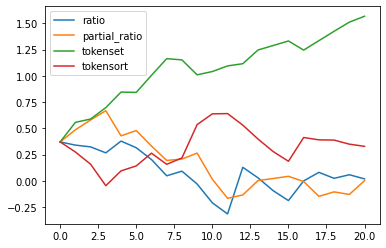

In [19]:
plt.plot(np.vstack(myActiveLearner.parameters));
plt.legend(['ratio', 'partial_ratio', 'tokenset', 'tokensort']);

## Blocking

In [20]:
X_training = myActiveLearner.learner.X_training
y_training = myActiveLearner.learner.y_training

In [21]:
myBlocking = Blocking('col').fit(X_training, y_training)

In [22]:
myBlocking.rules_selected

['first_word',
 'first_two_words',
 'first_three_letters',
 'first_four_letters',
 'first_five_letters',
 'first_three_letters_no_space',
 'first_four_letters_no_space',
 'first_five_letters_no_space']

In [23]:
pairs_table = myBlocking.transform(X_pool[:,0])
pairs_table.head(2)

,col_1,fingerprint,col_2
0,banco bilbao vizcaya argentaria s a 48005 bilbao spain,banco:0,banco bilbao vizcaya argentaria s a 48005 bilbao spain
1,banco bilbao vizcaya argentaria s a 48005 bilbao spain,banco:0,banco santander s a 28660 madrid spain


## Scoring

In [24]:
scored_pairs_table = pairs_table.copy()

In [25]:
scored_pairs_table['score'] = myActiveLearner.predict_proba(pairs_table[['col_1', 'col_2']].values)[:,1]

In [26]:
scored_pairs_table.loc[scored_pairs_table.col_1==scored_pairs_table.col_2, 'score'] = 1

In [27]:
scored_pairs_table.head(2)

,col_1,fingerprint,col_2,score
0,banco bilbao vizcaya argentaria s a 48005 bilbao spain,banco:0,banco bilbao vizcaya argentaria s a 48005 bilbao spain,1.000000
1,banco bilbao vizcaya argentaria s a 48005 bilbao spain,banco:0,banco santander s a 28660 madrid spain,0.282174


## Hierarchical clustering

In [28]:
df_clusters = hierarchical_clustering(scored_pairs_table)
df_clusters.head()

,cluster_id
banco bilbao vizcaya argentaria s a bilbao,1
banco bilbao vizcaya argentaria s a 48005 bilbao spain,1
banco bilbao vizcaya argentaria s a plaza san nicolas 4 48005 spain,1
banco santander s a 28660 madrid spain,2
banco santander s a 28660 madrid,2


## All in one

In [30]:
myDedupliPy = Deduplicator(X_initial, y_initial, 'col', 10)

In [31]:
myDedupliPy.fit(X_pool)


1/10 [0.37043145 0.37043145 0.37043145 0.37043145]
Is this a match?
-> bnp paribas sa paris
-> bnp paribas sa 16 boulevard des italiens 75009 france


 y



2/10 [0.34004534 0.48584379 0.55653434 0.27457653]
Is this a match?
-> bnp paribas sa paris
-> axa sa 75008 paris france


 n



3/10 [0.32314749 0.57960843 0.58861461 0.15793533]
Is this a match?
-> danone s a  15  rue du helder paris france
-> essilorluxottica 1 6 rue paul cezanne paris france


 n



4/10 [ 0.26641127  0.66791722  0.69726937 -0.04651161]
Is this a match?
-> eni s p a  piazzale enrico mattei 1 rome italy
-> eni s p a  rm 00144 rome italy


 y



5/10 [0.37834246 0.42831235 0.84501967 0.09465863]
Is this a match?
-> telefonica  s a  ronda de la comunicacion
-> telefonica  s a  28050 madrid


 y



6/10 [0.3148192  0.47866036 0.84236858 0.14190461]
Is this a match?
-> engie sa 1  place samuel de champlain 92400 france
-> engie sa 92400 courbevoie france


 y



7/10 [0.20268339 0.33099464 1.00441754 0.26320664]
Is this a match?
-> l air liquide s a  75007 paris france
-> sanofi 54  rue la boetie 75008 paris france


 n



8/10 [0.04777733 0.19396337 1.1633721  0.15696785]
Is this a match?
-> telefonica  s a  28050 madrid
-> telefonica  s a  ronda de la comunicacion


 y



9/10 [0.09189256 0.20713614 1.15166827 0.21784915]
Is this a match?
-> total s a  paris
-> orange s a  75015 paris france


 n



10/10 [-0.03042021  0.26413328  1.00929043  0.53522591]
Is this a match?
-> basf se 67056 ludwigshafen am rhein  germany
-> basf se carl bosch strasse 38 67056 germany


 y


In [32]:
res = myDedupliPy.predict(X_pool)
res.head()

,cluster_id
banco santander s a 28660 madrid spain,1
banco santander s a 28660 madrid,1
banco santander s a 28660,1
banco bilbao vizcaya argentaria s a bilbao,2
banco bilbao vizcaya argentaria s a 48005 bilbao spain,2
